In [22]:
import math
import numpy as np 
import pandas as pd 
import datetime

In [23]:
import scipy.stats as stats 
import matplotlib.pyplot as plt 
from pandas_datareader import data as pdr 

C:\Users\chira\AppData\Local\Temp\ipykernel_424\3677364413.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stockData = yf.download(stocks, start=start, end=end)['Close']
[*********************100%***********************]  3 of 3 completed


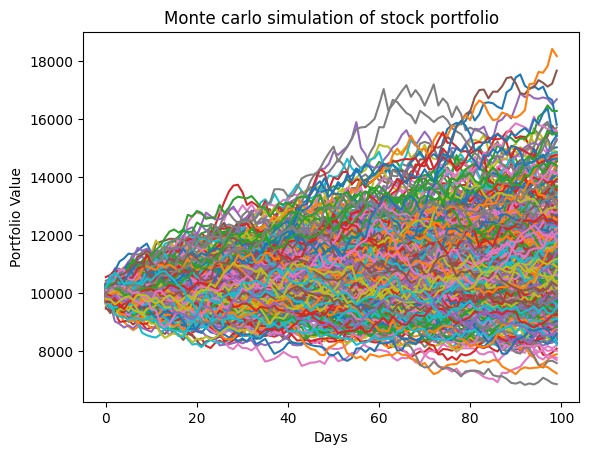

VaR_5 $1500.97
CVaR_5 $1920.9


In [24]:
import yfinance as yf
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix
stockList = ['AAPL', 'MSFT', 'GOOG']
stocks = [stock for stock in stockList]
endDate= datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

mc_sims = 400  # Monte Carlo simulations
T = 100  # number of time steps

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initialPortfolio = 10000

for m in range(mc_sims):
    z = np.random.normal(size=(T, len(weights)))  # Standard normal variables for each stock and time step
    L = np.linalg.cholesky(covMatrix)  # Cholesky decomposition of the covariance matrix
    dailyReturns = meanM + np.inner(L, z)  # Daily returns simulation
    portfolio_sims[:, m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolio  # Portfolio value over time


plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value')
plt.xlabel('Days')
plt.title('Monte carlo simulation of stock portfolio')
plt.show()

def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")


portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))

In [25]:
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.01            #risk-free rate (%)
N = 100              #number of time steps
M = 1000            #number of simulations

market_value = 3.86 #market price of option
T = ((datetime.date(2025, 10, 17)-datetime.date(2025,9,16)).days+1)/365    #time in years
print(T)

0.08767123287671233


In [26]:
#precompute constants
N = 100
dt = T / N
nudt = (r - 0.5 * vol**2) * dt
volsdt = vol * np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Simulation for Option Price
Z = np.random.normal(size=(N, M))  # Simulate random normal values
delta_lnSt = nudt + volsdt * Z  # Log returns for each time step
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)  # Simulate stock price paths
lnSt = np.concatenate((np.full(shape=(1, M), fill_value=lnS), lnSt))  # Add the initial price to the simulation

# Compute the option payoff
ST = np.exp(lnSt)  # Convert log prices back to stock prices
CT = np.maximum(0, ST - K)  # Option payoff: max(0, S_T - K)
C0 = np.exp(-r * T) * np.sum(CT[-1]) / M  # Discounted option price

# Calculate standard error
sigma = np.sqrt(np.sum((CT[-1] - C0) ** 2) / (M - 1))  # Variance of the payoffs
SE = sigma / np.sqrt(M)  # Standard error

print(f"Call value is ${np.round(C0, 2)} with SE +/- {np.round(SE, 2)}")

Call value is $3.37 with SE +/- 0.08


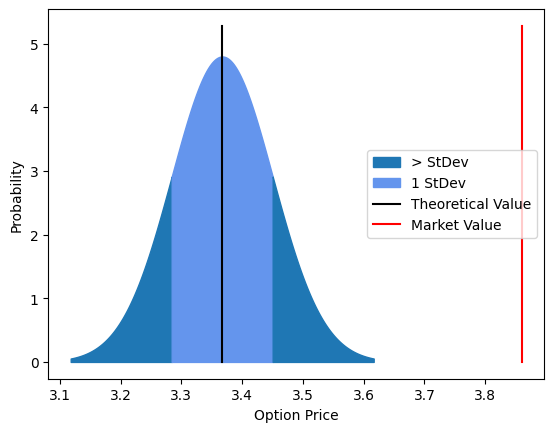

In [27]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()